# Data for CSCI 7000 final

## Imports

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

## Data

In [111]:
os.chdir("/data/jake/csci_7000-final_project")
print(os.getcwd(), os.listdir())

/data/jake/csci_7000-final_project ['csci_7000-genes.tsv', 'test.tsv', 'csci_7000-gene_subsetting.ipy', 'data.ipynb', 'samples_1kg', 'gargs.log']


In [112]:
# all 1kg giggle files
giggle_1kg = "/data/jake/genefusion/data/2024_11_01-fusions-1kg/giggle"
os.listdir(giggle_1kg)[:5]

['1.pos.CCDC28B.32665987.32670988.giggle',
 '2.pos.AC074117.10.27579113.27590489.giggle',
 '3.pos.CRELD1.9975506.9987097.giggle',
 '1.neg.IVNS1ABP.185265520.185286461.giggle',
 '16.neg.NPIPB7.28467693.28481868.giggle']

### Gene list

- See ipy file for subset heuristic

In [113]:
df = pd.read_csv("./csci_7000-genes.tsv", sep="\t", header=None)
df.columns = ["gene1", "gene2"]
df.head()

,gene1,gene2
0,TNRC6B,LRP1B
1,TNRC6B,ASH1L
2,TNRC6B,IQCJnegSCHIP1
3,TNRC6B,CACNA1E
4,TNRC6B,KIAA1671


In [114]:
genes = set(pd.concat([df["gene1"], df["gene2"]]).unique())

In [ ]:
def filestring2data(string):
    # assumes .giggle extension
    chrm = string.split(".")[0]
    strand = string.split(".")[1]
    gene = string.split(".")[2]
    start = string.split(".")[-3]
    end = string.split(".")[-2]
    # handle rare case where gene name has a period
    if len(string.split(".")) >= 7:
        gene = ".".join(string.split(".")[2:-3])
    return [chrm, strand, gene, start, end]

In [116]:
filestring2data("21.neg.AP000304.12.34956993.35284635.giggle")

['21', 'neg', 'AP000304.12', '34956993', '35284635']

### Gene giggles

In [117]:
# map genes to giggle files
fmap = {k: None for k in genes}
for f in os.listdir(giggle_1kg):
    _, _, gene, _, _ = filestring2data(f)
    if gene in fmap.keys():
        fmap[gene] = f

In [118]:
list(fmap.items())[0:5]

[('VPS13D', '1.pos.VPS13D.12290124.12572099.giggle'),
 ('DCC', '18.pos.DCC.49866542.51057784.giggle'),
 ('ARHGAP6', 'X.neg.ARHGAP6.11136239.11683821.giggle'),
 ('ASIC2', '17.neg.ASIC2.31340105.32501983.giggle'),
 ('SLC14A2', '18.pos.SLC14A2.42792960.43263072.giggle')]

In [119]:
df_fmap = pd.DataFrame(list(fmap.items()), columns=["gene", "file"])
df_fmap.head()

,gene,file
0,VPS13D,1.pos.VPS13D.12290124.12572099.giggle
1,DCC,18.pos.DCC.49866542.51057784.giggle
2,ARHGAP6,X.neg.ARHGAP6.11136239.11683821.giggle
3,ASIC2,17.neg.ASIC2.31340105.32501983.giggle
4,SLC14A2,18.pos.SLC14A2.42792960.43263072.giggle


In [120]:
df_giggle = pd.read_csv(
    os.path.join(giggle_1kg, df_fmap["file"][0]), sep="\t", header=None
)
giggle_columns = [
    "l_chrm",
    "l_start",
    "l_end",
    "strand",
    "r_chrm",
    "r_start",
    "r_end",
    "strand",
    "unknown",
    "sample",
]
df_giggle.columns = giggle_columns
df_giggle.head()

,l_chrm,l_start,l_end,strand,r_chrm,r_start,r_end,strand,unknown,sample
0,1,12315035,12315134,-1,5,13507894,13507973,-1,0,alt_sort/HG00096.bed.gz
1,1,12344923,12345023,-1,7,2018079,2018178,-1,0,alt_sort/HG00096.bed.gz
2,1,12386032,12386131,-1,5,22740652,22740752,1,0,alt_sort/HG00096.bed.gz
3,1,12433155,12433190,-1,18,4705296,4705395,-1,0,alt_sort/HG00096.bed.gz
4,1,12477324,12477423,1,1,12477548,12477648,-1,0,alt_sort/HG00096.bed.gz


In [121]:
# read giggle if not empty
def read_giggle(path):
    # handle empty file case for lexicographically high ranked files
    # which are often right intervals
    # thus, no giggle hits when it is query/source
    if not (os.path.getsize(path) == 0):
        df = pd.read_csv(path, sep="\t", header=None)
        df.columns = [
            "l_chrm",
            "l_start",
            "l_end",
            "strand",
            "r_chrm",
            "r_start",
            "r_end",
            "strand",
            "unknown",
            "sample",
        ]
        return df
    else:
        return None


df_giggle = read_giggle(os.path.join(giggle_1kg, df_fmap["file"][0]))
df_giggle.head()

,l_chrm,l_start,l_end,strand,r_chrm,r_start,r_end,strand,unknown,sample
0,1,12315035,12315134,-1,5,13507894,13507973,-1,0,alt_sort/HG00096.bed.gz
1,1,12344923,12345023,-1,7,2018079,2018178,-1,0,alt_sort/HG00096.bed.gz
2,1,12386032,12386131,-1,5,22740652,22740752,1,0,alt_sort/HG00096.bed.gz
3,1,12433155,12433190,-1,18,4705296,4705395,-1,0,alt_sort/HG00096.bed.gz
4,1,12477324,12477423,1,1,12477548,12477648,-1,0,alt_sort/HG00096.bed.gz


In [122]:
# setup outdir for giggle subset
outdir = "/data/jake/csci_7000-final_project/samples_1kg/giggle"

In [123]:
def write_giggle(df, path, mode="a"):
    df.to_csv(path, sep="\t", index=False, header=False, mode=mode)


write_giggle(df_giggle, "test.tsv")

### Sample-wise giggles

In [ ]:
def split_giggle_samples(file):
    gene = filestring2data(file)[2]
    path = os.path.join(giggle_1kg, file)
    df_giggle = read_giggle(path)
    if type(df_giggle) != type(None):
        df_giggle["sample"] = df_giggle["sample"].apply(
            lambda x: os.path.basename(x).split(".")[0]
        )
        # print(df_giggle['sample'])
        for sample, group in df_giggle.groupby("sample"):
            write_giggle(group, os.path.join(outdir, f"{sample}.{gene}.tsv"), mode="w")


files = list(df_fmap["file"])
cpus = 50
with mp.Pool(cpus) as pool:
    pool.map(split_giggle_samples, files)

### Intersect

- Group by sample
- Write sample-wise results to files
    - `split_giggle_samples`
- Do intersect for gene2gene variants
    - `genefile='/data/jake/genefusion/data/gene_file_cln.txt'`
    - `outdir=''`
    - `bedtools=''`
    - `ls | gargs --log ../gargs.log -p 64 -o "$bedtools intersect -a $genefile -b <(cut -f 5-7 {0}) > $outdir/{0}.g2g"`

- Convert fusion results to vector

In [ ]:
dir_g2g_1kg = "/data/jake/csci_7000-final_project/samples_1kg/gene2gene"

In [127]:
os.listdir(dir_g2g_1kg)[:5]

['NA18614.CSMD2.tsv.fusions',
 'HG01918.CTNNA2.tsv.fusions',
 'NA18546.DCC.tsv.fusions',
 'HG02855.RBMS3.tsv.fusions',
 'HG03565.CPNE4.tsv.fusions']

In [ ]:
def read_gene2gene(file):
    df = pd.read_csv(file, sep="\t", header=None, usecols=[3])
    df.columns = ["target"]
    return df


read_gene2gene(os.path.join(dir_g2g_1kg, "HG00096.ALK.tsv.fusions")).head()

,target
0,RP11neg611E13.2
1,RP11neg611E13.2
2,DLEU7
3,DLEU7negAS1
4,ATP1A3


### Location map

In [ ]:
gene_file = "/data/jake/genefusion/data/gene_file_cln.txt"
df_gene_file = pd.read_csv(gene_file, sep="\t", header=None)
df_gene_file.columns = ["chrm", "start", "end", "gene", "strand"]
df_gene_file.head()

,chrm,start,end,gene,strand
0,1,69091,70008,OR4F5,pos
1,1,134901,139379,AL627309.1,neg
2,1,139790,140339,RP11neg34P13.14,neg
3,1,367640,368634,OR4F29,pos
4,1,621059,622053,OR4F16,neg


In [ ]:
# subset
mask = df_gene_file["gene"].apply(lambda x: x in genes)
df_gene_file = df_gene_file[mask]
df_gene_file.head()

,chrm,start,end,gene,strand
145,1,6845384,7829766,CAMTA1,pos
159,1,8412457,8877702,RERE,neg
227,1,12290124,12572099,VPS13D,pos
261,1,14925200,15444539,KAZN,pos
308,1,17066768,17299474,CROCC,pos


- the gene file is already lexicographically sorted for chromosomes
- a second and thrid level sorts by start and end coordinates

In [ ]:
g2g_comb = list(itertools.combinations(df_gene_file["gene"].tolist(), 2))
g2g_comb = pd.DataFrame(g2g_comb)
g2g_comb.columns = ["source", "target"]
g2g_comb

,source,target
0,CAMTA1,RERE
1,CAMTA1,VPS13D
2,CAMTA1,KAZN
3,CAMTA1,CROCC
4,CAMTA1,EIF4G3
...,...,...
18716,ARHGAP6,IL1RAPL1
18717,ARHGAP6,DMD
18718,FRMPD4,IL1RAPL1
18719,FRMPD4,DMD


### Vectorize samples

In [ ]:
def init_vector(g2g_comb):
    return pd.Series(
        np.zeros(g2g_comb.shape[0], dtype=np.int64),
        index=g2g_comb.apply(lambda row: f"{row['source']}-{row['target']}", axis=1),
    )


init_vector(g2g_comb)

CAMTA1-RERE         0
CAMTA1-VPS13D       0
CAMTA1-KAZN         0
CAMTA1-CROCC        0
CAMTA1-EIF4G3       0
                   ..
ARHGAP6-IL1RAPL1    0
ARHGAP6-DMD         0
FRMPD4-IL1RAPL1     0
FRMPD4-DMD          0
IL1RAPL1-DMD        0
Length: 18721, dtype: int64

In [ ]:
def sample2vec(sample, dir_g2g, smooth=False):
    pattern = rf"^{sample}."
    files = [i for i in os.listdir(dir_g2g) if re.search(pattern, i)]
    v = init_vector(g2g_comb)
    v.name = sample
    for file in files:
        # handle case where gene name includes periods
        path = os.path.join(dir_g2g, file)
        if not (os.stat(path).st_size == 0):
            gene = "".join(file.split(".")[1:-2])
            if gene not in genes:
                continue
            df = read_gene2gene(path)
            for i, row in df.iterrows():
                target = row["target"]
                if (target in genes) and (gene != target):
                    if f"{gene}-{target}" in v.index:
                        v[f"{gene}-{target}"] += 1
                    elif f"{target}-{gene}" in v.index:
                        v[f"{target}-{gene}"] += 1
                    else:
                        raise ValueError(
                            f"Gene pair {gene}-{target} not in vector index"
                        )
            # target =
            # df['g2g'] = df['target'].apply(lambda x: f'{gene}-{x}')
            # s = df['g2g'].value_counts()
            # s.name = gene
            # for idx, val in s.items():
            #     # test if target is also in supported gene subset
            #     print( idx); return
            #     if idx in genes:
            #         # test if idx is in v index
            #         # if not, then it is a reverse pair
            #         print(idx)
            #         return
            #         if f'{idx.split("-")[1]}-{idx.split("-")[0]}' not in v.index:
            #             v[idx] = val
            #         else:
            #             v[f"{idx.split('-')[1]}-{idx.split('-')[0]}"] = val
    v.sort_index(inplace=True)
    if smooth:
        v = v.apply(lambda x: x + 1)
    return v


v = sample2vec("NA19394", dir_g2g_1kg, smooth=True)
v.head()

ACYP2-AFF3           1
ACYP2-AGAP1          1
ACYP2-AP000304.12    1
ACYP2-APP            1
ACYP2-ARHGAP15       1
Name: NA19394, dtype: int64

In [154]:
v.max()

np.int64(3)

In [ ]:
v2 = sample2vec("HG00096", dir_g2g_1kg, True)
v2.head()

ACYP2-AFF3           1
ACYP2-AGAP1          1
ACYP2-AP000304.12    1
ACYP2-APP            1
ACYP2-ARHGAP15       1
Name: HG00096, dtype: int64

In [ ]:
s2 = v2.sum()
q = v2.apply(lambda x: x / s2)

In [ ]:
s1 = v.sum()
p = v.apply(lambda x: x / s1)

In [ ]:
kl = entropy(p, q)
kl

np.float64(0.01072363362371668)

In [176]:
samples = [i.split(".")[0] for i in os.listdir(dir_g2g_1kg)]
samples = pd.Series(samples).unique().tolist()
len(samples)

2535

In [ ]:
# takes about 3 minutes
cpus = 44
p_sample2vec = partial(sample2vec, dir_g2g=dir_g2g_1kg, smooth=True)
with mp.Pool(cpus) as pool:
    vecs = pool.map(p_sample2vec, samples)

In [ ]:
df_vec = pd.concat(vecs, axis=1).T
df_vec

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19063,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,2,1,2,1,1
HG00105,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG03385,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NA19461,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
df_vec.to_csv("/data/jake/csci_7000-final_project/1kg-g2g_vecs.tsv", sep="\t")

### Pairwise KL

In [ ]:
# get all combinations of sample pairs
sample_pairs = list(itertools.combinations(samples, 2))
print(len(sample_pairs))
sample_pairs[:2]

3211845


[('NA18614', 'HG01918'), ('NA18614', 'NA18546')]

In [ ]:
def compute_pairwise_kl(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    q = s2 / s2.sum()
    p = s1 / s1.sum()
    kl = entropy(p, q)
    return sample_pair, kl


compute_pairwise_kl(sample_pairs[0], df_vec)

(('NA18614', 'HG01918'), np.float64(0.03506412975184324))

In [ ]:
# takes about 2.5 min
cpus = 44
p_compute_pairwise_kl = partial(compute_pairwise_kl, df_vec=df_vec)
with mp.Pool(cpus) as pool:
    kls = pool.map(p_compute_pairwise_kl, sample_pairs)
kls[:5]

[(('NA18614', 'HG01918'), np.float64(0.03506412975184324)),
 (('NA18614', 'NA18546'), np.float64(0.046144937017003985)),
 (('NA18614', 'HG02855'), np.float64(0.024378588255198775)),
 (('NA18614', 'HG03565'), np.float64(0.025647652023445024)),
 (('NA18614', 'NA19324'), np.float64(0.0220338328573092))]

In [ ]:
df_kl_1kg = pd.DataFrame(kls, columns=["sample_pair", "kl"])
df_kl_1kg.head()

,sample_pair,kl
0,"(NA18614, HG01918)",0.035064
1,"(NA18614, NA18546)",0.046145
2,"(NA18614, HG02855)",0.024379
3,"(NA18614, HG03565)",0.025648
4,"(NA18614, NA19324)",0.022034


In [ ]:
df_kl_1kg[["s_i", "s_j"]] = pd.DataFrame(
    df_kl_1kg["sample_pair"].tolist(), index=df_kl_1kg.index
)
df_kl_1kg.drop("sample_pair", axis=1, inplace=True)
# reorder columns
df_kl_1kg = df_kl_1kg[["s_i", "s_j", "kl"]]
df_kl_1kg["kl_neg_log10"] = df_kl_1kg["kl"].apply(lambda x: -np.log10(x))
df_kl_1kg.head()

,s_i,s_j,kl,kl_neg_log10
0,NA18614,HG01918,0.035064,1.455137
1,NA18614,NA18546,0.046145,1.335876
2,NA18614,HG02855,0.024379,1.612991
3,NA18614,HG03565,0.025648,1.590952
4,NA18614,NA19324,0.022034,1.656910


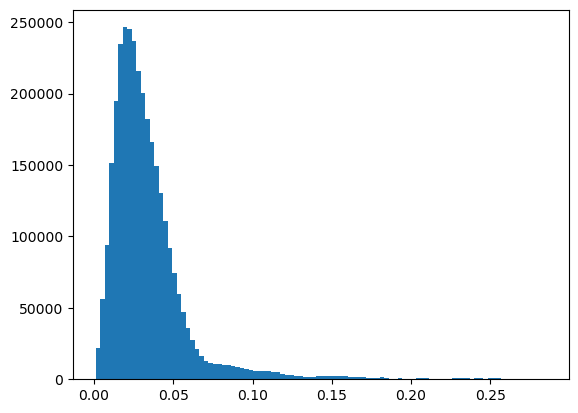

In [ ]:
df_kl_1kg["kl"].hist(bins=100)
plt.grid(False)

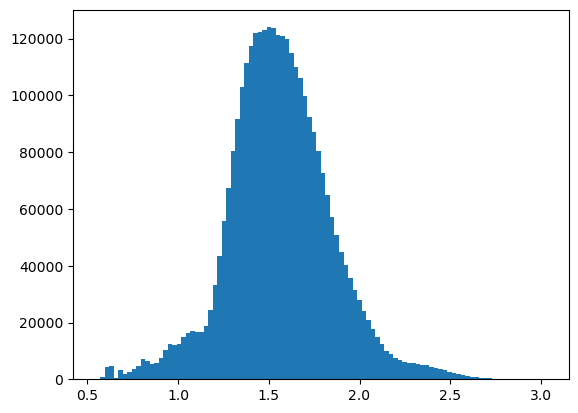

In [ ]:
df_kl_1kg["kl_neg_log10"].hist(bins=100)
plt.grid(False)

In [ ]:
# standard scale kl trans
sc = StandardScaler()
df_kl_1kg["kl_neg_log10_z"] = sc.fit_transform(
    df_kl_1kg["kl_neg_log10"].to_numpy().reshape(-1, 1)
)
df_kl_1kg.head()

,s_i,s_j,kl,kl_neg_log10,kl_neg_log10_z
0,NA18614,HG01918,0.035064,1.455137,-0.373640
1,NA18614,NA18546,0.046145,1.335876,-0.790457
2,NA18614,HG02855,0.024379,1.612991,0.178061
3,NA18614,HG03565,0.025648,1.590952,0.101034
4,NA18614,NA19324,0.022034,1.656910,0.331556


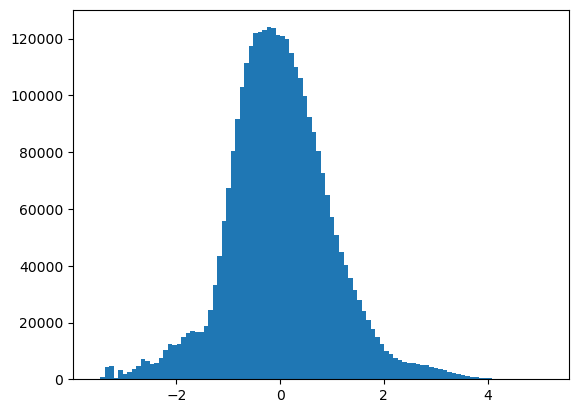

In [ ]:
df_kl_1kg["kl_neg_log10_z"].hist(bins=100)
plt.grid(False)

In [ ]:
df_kl_1kg.to_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_kl.tsv", sep="\t", index=False
)

In [ ]:
pd.read_csv("/data/jake/csci_7000-final_project/1kg-g2g_kl.tsv", sep="\t").head()

,s_i,s_j,kl,kl_trans
0,NA18614,HG01918,0.035064,1.455137
1,NA18614,NA18546,0.046145,1.335876
2,NA18614,HG02855,0.024379,1.612991
3,NA18614,HG03565,0.025648,1.590952
4,NA18614,NA19324,0.022034,1.656910


In [ ]:
df_kl_1kg.head()

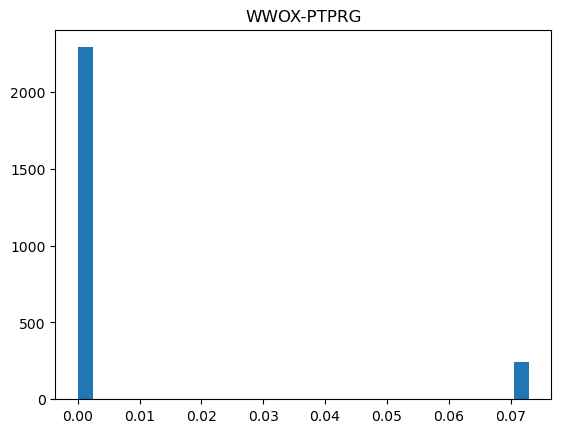

In [ ]:
# g2g features are power law distributed, concentrated around 1 (0 without smoothing)
df_vec.sample(1, axis=1).apply(lambda x: boxcox(x)[0]).hist(bins=30)
plt.grid(False)

## Baselines

### Johnson lindenstrauss

In [288]:
np.random.seed(0)

In [289]:
# distortion threshold
epsilon = 0.1
# compute dimensionality
# such that the distortion is less than epsilon
n = 2500
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

2086

In [290]:
jl_transformer = GaussianRandomProjection(n_components=k, random_state=0)
df_vec_transformed = pd.DataFrame(jl_transformer.fit_transform(df_vec))
print(df_vec_transformed.shape)
df_vec_transformed.index = df_vec.index
df_vec_transformed.head()

(2535, 2086)


,0,1,2,3,4,5,6,7,8,9,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
NA18614,-2.051126,-1.456229,1.092002,-2.992604,5.724252,6.829133,3.691685,6.263694,6.066922,-0.738450,...,0.272980,0.782090,3.451776,2.813435,1.412871,4.385370,3.945090,-1.796855,-3.564690,-0.671526
HG01918,-4.188421,-2.929395,1.031436,-3.002698,6.823088,4.705258,4.560896,7.202094,4.654009,-2.028744,...,0.236549,2.388977,1.831683,3.435842,1.664522,3.971462,2.639332,-2.005333,-2.661582,-0.368578
NA18546,-1.617051,-2.816215,-0.656346,-1.867814,6.993427,5.637329,4.379765,7.822922,4.497582,-0.964018,...,0.792185,3.809103,3.518849,3.948816,0.977811,5.082008,2.365027,-2.099849,-2.363069,-2.201466
HG02855,-3.507558,-2.334668,1.478754,-2.366508,5.864569,5.478177,4.399189,5.801723,3.456933,-0.583059,...,1.128956,1.588741,1.296292,2.986274,1.078364,4.191972,3.878989,-1.570710,-2.510935,-0.947581
HG03565,-2.866200,-2.596682,1.888015,-2.184448,6.031157,5.951043,4.294785,5.342199,4.487081,-1.275908,...,1.151451,1.673860,2.108185,3.293141,1.698277,3.719313,3.614750,-1.794606,-2.213681,-0.841359


In [298]:
samples2 = df_vec.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

HG03780 HG04054


In [299]:
tsne_original = TSNE(n_components=2, random_state=0)
df_tsne_original = pd.DataFrame(tsne_original.fit_transform(df_vec))
df_tsne_original.index = df_vec.index

tsne_jl = TSNE(n_components=2, random_state=0)
df_tsne_jl = pd.DataFrame(tsne_jl.fit_transform(df_vec_transformed))
df_tsne_jl.index = df_vec.index


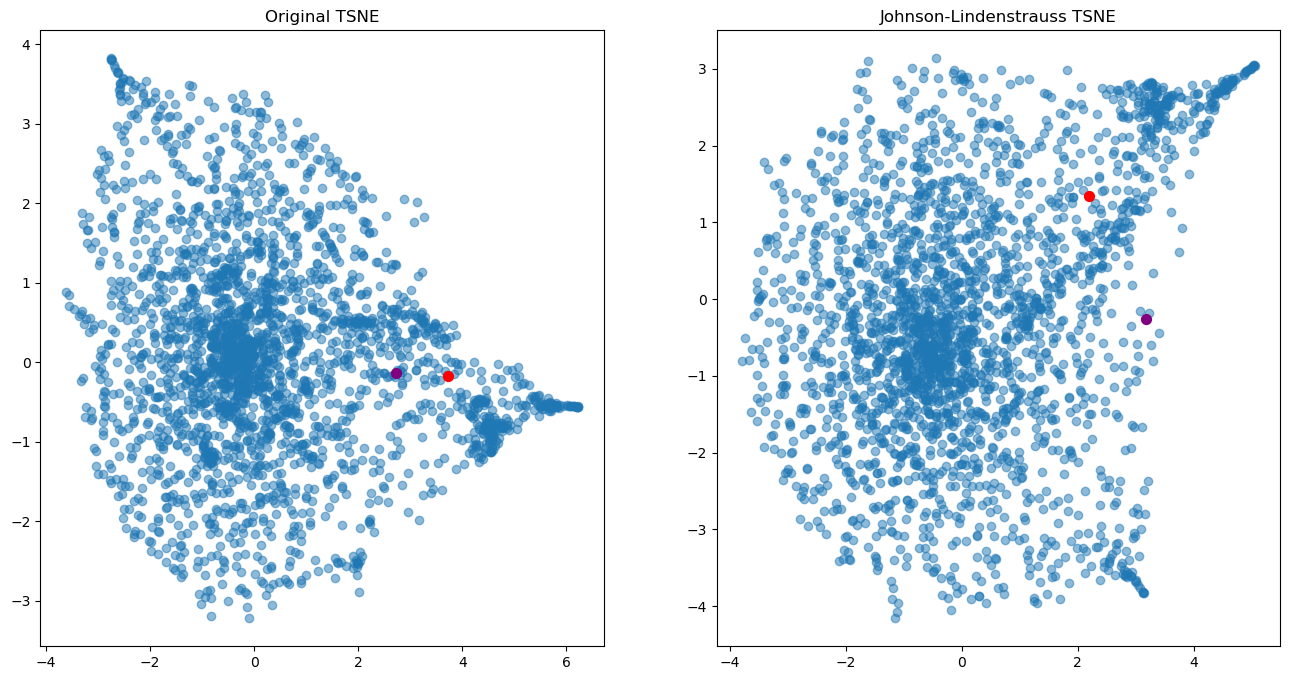

In [304]:
# plot original and jl tsne

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(df_tsne_original.iloc[:, 0], df_tsne_original.iloc[:,1], alpha=0.5)
axes[0].set_title("Original TSNE")
axes[0].scatter(df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1], color='red', s=50, label='Point 1')
axes[0].scatter(df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1], color='purple', s=50, label='Point 2')
# axes[0].annotate('Point 1', (df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[0].annotate('Point 2', (df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

axes[1].scatter(df_tsne_jl.iloc[:, 0], df_tsne_jl.iloc[:,1], alpha=0.5)
axes[1].set_title("Johnson-Lindenstrauss TSNE")
axes[1].scatter(df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1], color='red', s=50, label='Point 1')
axes[1].scatter(df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1], color='purple', s=50, label='Point 2')
# axes[1].annotate('Point 1', (df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[1].annotate('Point 2', (df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

#### Epsilon = 0.05

In [306]:
# distortion threshold
epsilon = 0.05
# compute dimensionality
# such that the distortion is less than epsilon
n = 2500
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

8346

In [307]:
jl_transformer = GaussianRandomProjection(n_components=k, random_state=0)
df_vec_transformed = pd.DataFrame(jl_transformer.fit_transform(df_vec))
print(df_vec_transformed.shape)
df_vec_transformed.index = df_vec.index
df_vec_transformed.head()

(2535, 8346)


,0,1,2,3,4,5,6,7,8,9,...,8336,8337,8338,8339,8340,8341,8342,8343,8344,8345
NA18614,-1.025440,-0.728027,0.545936,-1.496123,2.861783,3.414157,1.845622,3.131472,3.033098,-0.369181,...,-1.635071,1.223963,-0.595971,-0.056969,-2.027429,-0.639990,-2.978909,1.882458,2.238071,-0.215450
HG01918,-2.093960,-1.464522,0.515656,-1.501169,3.411135,2.352347,2.280175,3.600616,2.326726,-1.014250,...,-1.051927,1.456325,0.345446,0.659130,-1.802837,-0.998883,-2.960917,1.615550,1.841080,-0.453684
NA18546,-0.808429,-1.407939,-0.328134,-0.933795,3.496295,2.818327,2.189620,3.910992,2.248522,-0.481951,...,-1.712473,1.457106,0.205576,0.590039,-1.667915,-1.018123,-3.333114,1.880983,2.245409,-1.040574
HG02855,-1.753569,-1.167194,0.739288,-1.183112,2.931933,2.738760,2.199331,2.900514,1.728260,-0.291495,...,-1.019134,1.043395,0.068507,0.573139,-2.300647,-1.152485,-1.995772,1.904557,1.577608,-0.908192
HG03565,-1.432928,-1.298186,0.943894,-1.092093,3.015217,2.975165,2.147135,2.670779,2.243272,-0.637878,...,-1.145276,1.114458,0.237670,0.446908,-2.199421,-1.238291,-2.308198,1.696419,1.618725,-0.514636


In [308]:
samples2 = df_vec.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

HG03780 HG04054


In [309]:
tsne_original = TSNE(n_components=2, random_state=0)
df_tsne_original = pd.DataFrame(tsne_original.fit_transform(df_vec))
df_tsne_original.index = df_vec.index

tsne_jl = TSNE(n_components=2, random_state=0)
df_tsne_jl = pd.DataFrame(tsne_jl.fit_transform(df_vec_transformed))
df_tsne_jl.index = df_vec.index


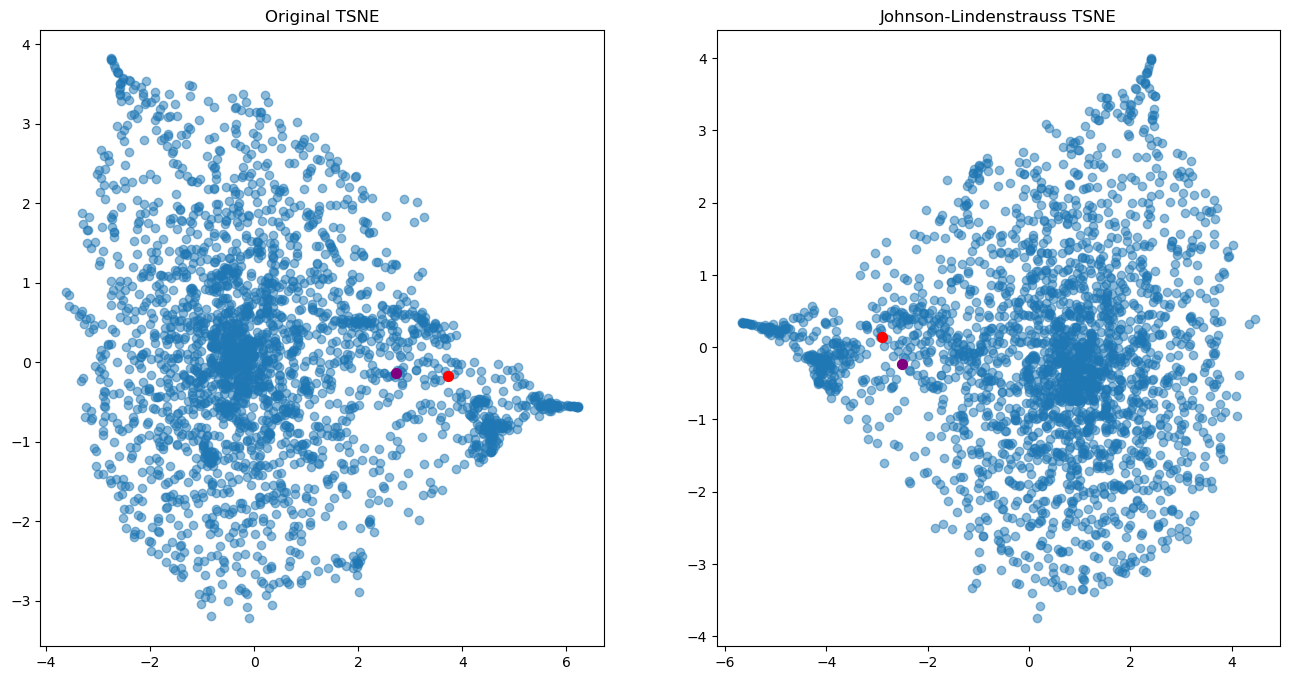

In [310]:
# plot original and jl tsne

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(df_tsne_original.iloc[:, 0], df_tsne_original.iloc[:,1], alpha=0.5)
axes[0].set_title("Original TSNE")
axes[0].scatter(df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1], color='red', s=50, label='Point 1')
axes[0].scatter(df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1], color='purple', s=50, label='Point 2')
# axes[0].annotate('Point 1', (df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[0].annotate('Point 2', (df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

axes[1].scatter(df_tsne_jl.iloc[:, 0], df_tsne_jl.iloc[:,1], alpha=0.5)
axes[1].set_title("Johnson-Lindenstrauss TSNE")
axes[1].scatter(df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1], color='red', s=50, label='Point 1')
axes[1].scatter(df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1], color='purple', s=50, label='Point 2')
# axes[1].annotate('Point 1', (df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[1].annotate('Point 2', (df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1]), 
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')